In [29]:
import torch
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
import os
import matplotlib.pyplot as plt
import copy
import cv2
import numpy as np


# Custom Dataset

In [48]:
class TestDataset(Dataset) :
    def __init__(self, path, transforms=None) :
        self.img_list = glob(os.path.join(path, "*"))
        # label은 임의로 설정
        self.label = [ i for i in range(0, len(self.img_list))]
        self.transforms = transforms
        
    def __getitem__(self, idx) :
        img = cv2.imread(self.img_list[idx], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label = self.label[idx]
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transforms :
            img = self.transforms(image=img)['image']

        return img, label
    
    def __len__(self) :
        return len(self.img_list)

# CutMix Visualization

In [49]:
transforms = A.Compose([
    A.Resize(200, 224),
    ToTensorV2()
])

# ==========================
path = './sample'
# ==========================

dataset = TestDataset(path, transforms=transforms)
# image shape = C H W to H W C
img1 = dataset[0][0].permute(1,2,0)
img2 = dataset[1][0].permute(1,2,0)

In [50]:
def cutmix(img1, img2, print_arg=False) :
    # H W C
    W = img1.shape[1]
    H = img1.shape[0]
    
    # beta distribution
    lam = np.random.beta(1.0, 1.0)
    
    # 중심 좌표
    rx = np.random.randint(W)
    ry = np.random.randint(H)
    # 가로 세로 길이
    rw = np.int(W * np.sqrt(1 - lam))
    rh = np.int(H * np.sqrt(1 - lam))
    
    # patch 
    x1 = np.clip(rx - rw//2, 0, W)
    y1 = np.clip(ry - rh//2, 0, H)
    x2 = np.clip(rx + rw//2, 0, W)
    y2 = np.clip(ry + rh//2, 0, H)
    
    if print_arg :
        print("lam : ", lam)
        print("x1 : ", x1)
        print("y1 : ", y1)
        print("x2 : ", x2)
        print("y2 : ", y2)
    
    img_tmp = copy.deepcopy(img1)
    img1[y1:y2, x1:x2, :] = img2[y1:y2, x1:x2, :]
    img2[y1:y2, x1:x2, :] = img_tmp[y1:y2, x1:x2, :]
    
    return img1, img2

lam :  0.521633687210819
x1 :  7
y1 :  0
x2 :  161
y2 :  74


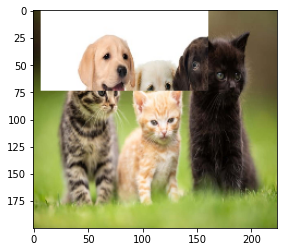

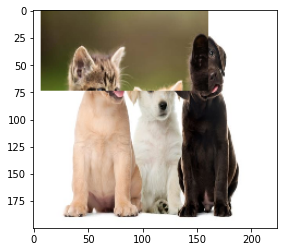

In [52]:
img1, img2 = cutmix(img1, img2, print_arg=True)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()


# CutMix with Training

In [41]:
def cutmix(imgs, rand_pick) :
    # B, C, H, W
    W = imgs.shape[3]
    H = imgs.shape[2]
    
    # beta distribution
    lam = np.random.beta(1.0, 1.0)
    
    # 중심 좌표
    rx = np.random.randint(W)
    ry = np.random.randint(H)
    # 가로 세로 길이
    rw = np.int(W * np.sqrt(1 - lam))
    rh = np.int(H * np.sqrt(1 - lam))
    
    # patch 
    x1 = np.clip(rx - rw//2, 0, W)
    y1 = np.clip(ry - rh//2, 0, H)
    x2 = np.clip(rx + rw//2, 0, W)
    y2 = np.clip(ry + rh//2, 0, H)
    
    # batch 에 포함된 모든 이미지에 rand_pick 번째 이미지를 크롭해서 넣음
    # rand_pick이 batch size만큼 있으므로 batch내의 모든 이미지들이 랜덤한 이미지들과 섞이게됨
    imgs[: , :, y1:y2, x1:x2] = imgs[rand_pick, : , y1:y2, x1:x2]
    
    # crop 비율에 맞춰 lambda 조절
    # 논문에는 1 - rxry/WH로 나와 있는데 실제 pixel 비율로 계산히기 위해 x1x2y1y2 사용
    # 수정된 lambda는 loss 계산에 이용
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    
    return imgs, lam

In [46]:
import timm
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

model = timm.create_model('resnet50', pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(params=model.parameters(), lr=0.0001)

transforms = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

# ==========================
path = './sample'
# ==========================

dataset = TestDataset(path, transforms=transforms)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

for batch_img, batch_label in dataloader :
    # image shape = B C H W
    imgs = batch_img.to(dtype=torch.float)

    # 0 ~ batch size 숫자들을 랜덤으로 나열해줌
    # torch.randperm(8) ->  [4, 2, 1, 0 ,5, 7]
    rand_pick = torch.randperm(imgs.shape[0])

    # label
    target_a = batch_label
    target_b = batch_label[rand_pick]
    
    # cutmix 적용 및 lambda 조절
    imgs, lam = cutmix(imgs, rand_pick)
    
    # cutmix에서 구한 lambda로 loss 값 구하기
    pred = model(imgs)
    loss = lam * criterion(pred, target_a) + (1 - lam)*criterion(pred, target_b)
    
    # backpropagation
    loss.backward()
    optimizer.step()
            
    print("loss : ", loss.item())
    
    
# pred = model(img3.float())

loss :  7.110896587371826
loss :  6.977312088012695
